In [1]:
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from operator import itemgetter
from sklearn.preprocessing import MinMaxScaler
# IR evaluation metrics
from ranx import evaluate
from tqdm import tqdm

# FIRST PART EVALUATION

## Functions

In [2]:
# determine if the 2 lists are equal
# return a list of missed id in bm25 and a list of missed id in trans
def equal_id(l_bm25, l_trans):
    # lists that contain the missing id docs
    missing_bm25, missing_trans = [], []
    # sort lists
    l_bm25.sort()
    l_trans.sort()
    # iterators
    i_bm25, i_trans = 0, 0
    while(i_bm25 < len(l_bm25) and i_trans < len(l_trans)):
        # equal value so I can go forward
        if (l_bm25[i_bm25] == l_trans[i_trans]):
            i_bm25 += 1
            i_trans += 1
        
        elif (l_bm25[i_bm25] < l_trans[i_trans]):
            missing_trans.append(l_bm25[i_bm25])
            i_bm25 += 1
        
        else:
            missing_bm25.append(l_trans[i_trans])
            i_trans += 1
    
    if (i_bm25 == len(l_bm25) and i_trans == len(l_trans)):
        return missing_bm25, missing_trans
    
    elif (i_bm25 != len(l_bm25)):
        return missing_bm25, missing_trans + l_bm25[i_bm25:]
    
    else:
        return missing_bm25 + l_trans[i_trans:], missing_trans
    
# determine the mean recall among all queries
def mean_recall(ground_truth, y_hat):
    m_recall = 0
    # for each query determine recall
    for k_query in ground_truth.keys():
        # extract relevant document retrieved
        tmp_set = set.intersection(set(ground_truth[k_query].keys()), set(y_hat[k_query].keys()))
        # compute recall for specific query
        m_recall += len(tmp_set) / len(list(ground_truth[k_query].keys()))
    # compute the mean among all recall
    return m_recall / len(ground_truth)

## Load dictionaries

In [3]:
# load dictionaries and extract them from array
d_score_BM25 = np.load('d_score_BM25.npy', allow_pickle=True).item()
d_score_TRANS = np.load('d_score_TRANS.npy', allow_pickle=True).item()
d_score_ground_truth = np.load('d_score_ground_truth.npy', allow_pickle=True).item()

## Extract ranking for different K

In [4]:
# total numbers of docs
num_docs = len(d_score_ground_truth[list(d_score_ground_truth.keys())[0]])
# final dict, it is composed by:
# K : (ground_truth, y_hat) where each of them is a dictionary where the key is the query id and the alue is anotehr dictionary
# where the key is the doc_id and the value is the score, this list is sorted from max to min score
final_score = {}
# compute the various ranking for different K
for K in [2**i for i in range(13)] + [num_docs]:
    # all query score for this K
    K_final_score = {}
    # each loop is a different query
    for q_key in d_score_BM25.keys():
        # extract first K for both score lists
        k_bm25 = list(d_score_BM25[q_key].items())[:K]
        k_trans = list(d_score_TRANS[q_key].items())[:K]
        # find documents that aren't present in top k for one of the 2 lists
        diff_bm25, diff_trans = equal_id([elem[0] for elem in k_bm25], [elem[0] for elem in k_trans])
        # insert missed document in the lists 
        # NB: get return the value of the key, if this key is not present is used the dafault value, that is 0
        k_bm25 += [(key, d_score_BM25[q_key].get(key, 0)) for key in diff_bm25]
        k_trans += [(key, d_score_TRANS[q_key].get(key, 0)) for key in diff_trans]
        # complete BM25 being that it doesn't contains all docs (due to sparse matrix)
        if K == num_docs:
            d_score_BM25[q_key] = dict(k_bm25)
        # transform in dict
        k_bm25 = dict(k_bm25)
        k_trans = dict(k_trans)
        # compute query final score adding each pair between lists
        query_final_score = [(key, k_bm25[key] + k_trans[key]) for key in k_bm25.keys()]
        # sort query final score 
        query_final_score = sorted(query_final_score, reverse=True, key=itemgetter(1))[:K]
        K_final_score[q_key] = dict(query_final_score)
    #                 (ground truth till k, y_hat till k)
    final_score[K] = ({key : dict(list(d_score_ground_truth[key].items())[:K]) for key in d_score_ground_truth.keys()},
                      K_final_score)

## Evaluate ranking for each K' (changing K  even for ground truth)

In [161]:
df_eval = pd.DataFrame(columns = ['K', 'MAP', 'MRR', 'NDCG', 'MRecall'])
for k in final_score.keys():
    eval_tmp = list((evaluate(final_score[k][0], final_score[k][1], ["map", "mrr", "ndcg"])).items()) 
    df_tmp = pd.DataFrame([[k] + [ev[1] for ev in eval_tmp] + [mean_recall(final_score[k][0], final_score[k][1])]],
                          columns = ['K', 'MAP', 'MRR', 'NDCG', 'MRecall'])
    df_eval = pd.concat([df_eval, df_tmp])

In [162]:
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 4)
df_eval

,K,MAP,MRR,NDCG,MRecall
0,1,0.9567,0.9567,0.9567,0.9567
0,2,0.9583,1.0000,0.9713,0.9583
0,4,0.9575,1.0000,0.9769,0.9575
0,8,0.9513,1.0000,0.9764,0.9513
0,16,0.9519,1.0000,0.9771,0.9519
0,32,0.9548,1.0000,0.9785,0.9548
0,64,0.9584,1.0000,0.9801,0.9571
0,128,0.9607,1.0000,0.9808,0.9545
0,256,0.9729,1.0000,0.9863,0.9618
0,512,0.9885,1.0000,0.9941,0.9718


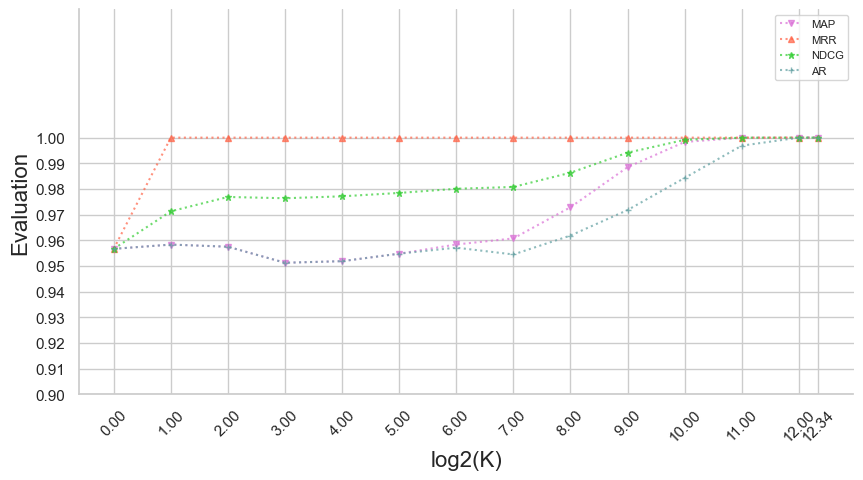

In [261]:
# plot evaluation
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sb.set_theme(style="whitegrid", rc=custom_params)
plt.figure(figsize=(10, 5))

x = np.around(np.log2(list(df_eval["K"])), 3)

plt.xticks(x, rotation = 45)
plt.yticks(np.arange(0, 1.01, 0.01))
plt.ylim(bottom=0.9, top=1.05) 
plt.xlabel("log2(K)", fontsize=16)
plt.ylabel("Evaluation", fontsize=16)

plt.plot(x,
         df_eval["MAP"],
         linestyle=':', marker="v", color="orchid", ms=5, alpha=0.7, label="MAP")

plt.plot(x,
         df_eval["MRR"],
         linestyle=':', marker="^", color="tomato", ms=5, alpha=0.7, label="MRR")

plt.plot(x,
         df_eval["NDCG"],
         linestyle=':', marker="*", color="limegreen", ms=5, alpha=0.7, label="NDCG")

plt.plot(x,
         df_eval["MRecall"],
         linestyle=':', marker="+", color="cadetblue", ms=5, alpha=0.7, label="AR")

plt.legend(fontsize=8)
plt.savefig('eval_1_changing_K.png', format='png', dpi=400, bbox_inches='tight')

### Understanding of above graph

In [106]:
df_eval_q = pd.DataFrame(columns = ['K', 'Q', 'method', 'best_is_in'])
for k in [1, 2, 4]:
    pbar = tqdm(list(d_score_BM25.keys()), desc="Loading....")
    for e, k_q in enumerate(d_score_BM25.keys()):
        best_doc = (list(final_score[k][0][k_q].items())[0])[0]
        b = list(d_score_BM25[k_q].items())[:k]
        b = [i for (i, j) in b]
        t = list(d_score_TRANS[k_q].items())[:k]
        t = [i for (i, j) in t]
        
        df_tmp_1 = pd.DataFrame([[k, e, "BM25"]+ [1 if best_doc in b  else 0]],
                              columns = ['K', 'Q', 'method', 'best_is_in'])
    
        df_tmp_2 = pd.DataFrame([[k, e, "TRANS"]+ [1 if best_doc in t else 0]],
                              columns = ['K', 'Q', 'method', 'best_is_in'])
        df_eval_q = pd.concat([df_eval_q, df_tmp_1, df_tmp_2])
        pbar.update()

Loading....: 100%|██████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 326.07it/s]

Loading....:  94%|█████████████████████████████████████████████████████████████▊    | 281/300 [00:00<00:00, 294.62it/s]

In [107]:
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 4)
df_eval_q

,K,Q,method,best_is_in
0,1,0,BM25,1
0,1,0,TRANS,0
0,1,1,BM25,0
0,1,1,TRANS,0
0,1,2,BM25,1
...,...,...,...,...
0,4,297,TRANS,1
0,4,298,BM25,1
0,4,298,TRANS,1
0,4,299,BM25,1


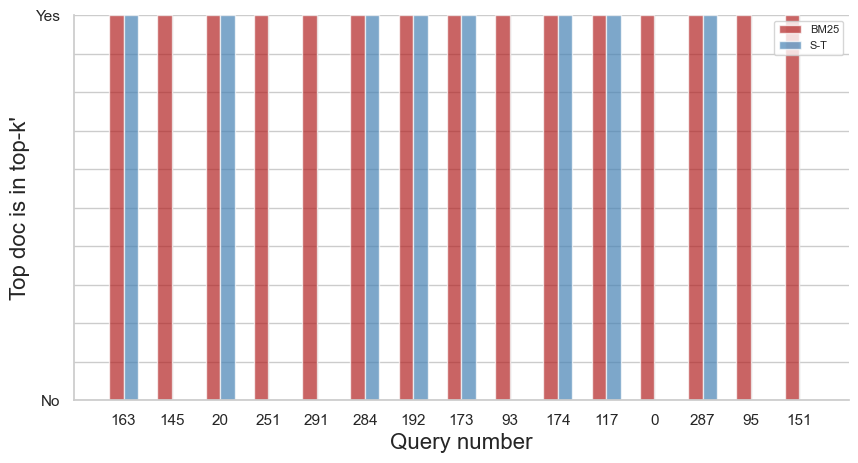

In [254]:
# plot evaluation
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sb.set_theme(style="whitegrid", rc=custom_params)
plt.figure(figsize=(10, 5))

r = np.random.randint(300, size=15)

x = np.arange(1, 30, 2)

plt.xticks(x, np.array(list(set(df_eval_q["Q"])))[r])
plt.yticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9,  1], ["No", "", "", "", "", "", "", "", "", "", "Yes"])
plt.ylim(top=1.0) 
plt.xlabel("Query number", fontsize=16)
plt.ylabel("Top doc is in top-k'", fontsize=16)


plt.bar(x - .3,
         df_eval_q[(df_eval_q["method"] == "BM25") & (df_eval_q["K"] == 2)]["best_is_in"].iloc[r],
         color="firebrick", width = 0.6, alpha = 0.7, label="BM25")

plt.bar(x + .3,
         df_eval_q[(df_eval_q["method"] == "TRANS") & (df_eval_q["K"] == 2)]["best_is_in"].iloc[r],
         color="steelblue", width = 0.6, alpha = 0.7, label="S-T")


plt.legend(fontsize=8)
plt.savefig('top_doc_is_in.png', format='png', dpi=400, bbox_inches='tight')

In [126]:
df_eval_q_2 = pd.DataFrame(columns = ['K', 'Q', 'method', 'best_is_in'])
for k in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 5183]:
    print(k)
    pbar = tqdm(list(d_score_BM25.keys()), desc="Loading....")
    for e, k_q in enumerate(d_score_BM25.keys()):
        best_docs = [i for (i, j) in list(final_score[k][0][k_q].items())[:k]]
        b = list(d_score_BM25[k_q].items())[:k]
        b = [i for (i, j) in b]
        t = list(d_score_TRANS[k_q].items())[:k]
        t = [i for (i, j) in t]
        
        df_tmp_1 = pd.DataFrame([[k, e, "BM25"] + [sum([b.count(b_) for b_ in best_docs])]],
                              columns = ['K', 'Q', 'method', 'best_is_in'])
        
        df_tmp_2 = pd.DataFrame([[k, e, "TRANS"] + [sum([t.count(b) for b in best_docs])]],
                              columns = ['K', 'Q', 'method', 'best_is_in'])
        df_eval_q_2 = pd.concat([df_eval_q_2, df_tmp_1, df_tmp_2])
        pbar.update()

1



Loading....:  89%|███████████████████████████████████████████████████████████▍       | 266/300 [00:10<00:01, 25.33it/s]

Loading....:  97%|████████████████████████████████████████████████████████████████▏ | 292/300 [00:01<00:00, 203.88it/s]

2


Loading....:  97%|████████████████████████████████████████████████████████████████▏ | 292/300 [00:01<00:00, 264.95it/s]

4



Loading....: 100%|██████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 270.23it/s]

Loading....: 100%|█████████████████████████████████████████████████████████████████▊| 299/300 [00:01<00:00, 195.00it/s]

8


Loading....:  97%|████████████████████████████████████████████████████████████████  | 291/300 [00:01<00:00, 218.72it/s]

16



Loading....: 100%|██████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 193.05it/s]

Loading....:  95%|██████████████████████████████████████████████████████████████▍   | 284/300 [00:01<00:00, 194.33it/s]

32


Loading....:  96%|███████████████████████████████████████████████████████████████▌  | 289/300 [00:01<00:00, 265.55it/s]

64



Loading....: 100%|██████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 192.60it/s]

Loading....:  97%|███████████████████████████████████████████████████████████████▊  | 290/300 [00:01<00:00, 187.79it/s]

128


Loading....:  97%|███████████████████████████████████████████████████████████████▊  | 290/300 [00:01<00:00, 148.26it/s]

256



Loading....: 100%|██████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 162.40it/s]

Loading....:  99%|█████████████████████████████████████████████████████████████████▎| 297/300 [00:02<00:00, 127.41it/s]

512


Loading....:  99%|██████████████████████████████████████████████████████████████████ | 296/300 [00:06<00:00, 55.83it/s]

1024



Loading....: 100%|███████████████████████████████████████████████████████████████████| 300/300 [00:06<00:00, 46.45it/s]

Loading....:  88%|██████████████████████████████████████████████████████████▋        | 263/300 [00:20<00:02, 14.71it/s]


Loading....: 100%|██████████████████████████████████████████████████████████████████▊| 299/300 [00:23<00:00, 15.95it/s]

2048


Loading....: 100%|███████████████████████████████████████████████████████████████████| 300/300 [01:08<00:00,  4.36it/s]

4096



Loading....: 100%|███████████████████████████████████████████████████████████████████| 300/300 [01:08<00:00,  4.38it/s]

Loading....:  44%|█████████████████████████████▎                                     | 131/300 [02:08<03:11,  1.13s/it]


Loading....:  88%|██████████████████████████████████████████████████████████▋        | 263/300 [04:20<00:46,  1.24s/it]


Loading....: 100%|███████████████████████████████████████████████████████████████████| 300/300 [04:59<00:00,  1.04it/s]

5183


Loading....: 100%|███████████████████████████████████████████████████████████████████| 300/300 [08:55<00:00,  1.66s/it]

In [127]:
df_eval_q_2

,K,Q,method,best_is_in
0,1,0,BM25,1
0,1,0,TRANS,0
0,1,1,BM25,0
0,1,1,TRANS,0
0,1,2,BM25,1
...,...,...,...,...
0,5183,297,TRANS,5183
0,5183,298,BM25,5183
0,5183,298,TRANS,5183
0,5183,299,BM25,5183


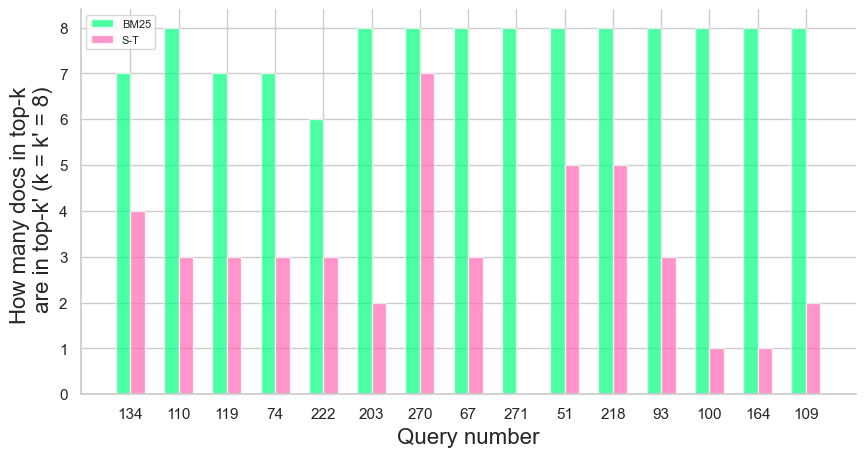

In [255]:
# plot evaluation
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sb.set_theme(style="whitegrid", rc=custom_params)
plt.figure(figsize=(10, 5))

r = np.random.randint(300, size=15)
k = 8
x = np.arange(1, 30, 2)

plt.xticks(x, np.array(list(set(df_eval_q_2["Q"])))[r])
plt.yticks(range(0, k+1))
# plt.ylim(top=1.0) 
plt.xlabel("Query number", fontsize=16)
plt.ylabel("How many docs in top-k \n are in top-k' (k = k' = 8)", fontsize=16)


plt.bar(x - .3,
         df_eval_q_2[(df_eval_q_2["method"] == "BM25") & (df_eval_q_2["K"] == k)]["best_is_in"].iloc[r],
         color="springgreen", width = 0.6, alpha = 0.7, label="BM25")

plt.bar(x + .3,
         df_eval_q_2[(df_eval_q_2["method"] == "TRANS") & (df_eval_q_2["K"] == k)]["best_is_in"].iloc[r],
         color="hotpink", width = 0.6, alpha = 0.7, label="S-T")


plt.legend(fontsize=8)
plt.savefig('how_many_docs_is_in.png', format='png', dpi=400, bbox_inches='tight')

#### Visualization of single method

In [129]:
for k in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 5183]:
    print(f'k = {k}, trans, {df_eval_q_2[(df_eval_q_2["K"] == k) & (df_eval_q_2["method"] == "TRANS")]["best_is_in"].mean()/k:.3f}')
    print(f'k = {k}, bm, {df_eval_q_2[(df_eval_q_2["K"] == k) & (df_eval_q_2["method"] == "BM25")]["best_is_in"].mean()/k:.3f}')
    print("--------------------")


k = 1, trans, 0.487
k = 1, bm, 0.933
--------------------
k = 2, trans, 0.457
k = 2, bm, 0.920
--------------------
k = 4, trans, 0.378
k = 4, bm, 0.934
--------------------
k = 8, trans, 0.353
k = 8, bm, 0.912
--------------------
k = 16, trans, 0.328
k = 16, bm, 0.914
--------------------
k = 32, trans, 0.314
k = 32, bm, 0.914
--------------------
k = 64, trans, 0.314
k = 64, bm, 0.912
--------------------
k = 128, trans, 0.318
k = 128, bm, 0.903
--------------------
k = 256, trans, 0.332
k = 256, bm, 0.906
--------------------
k = 512, trans, 0.383
k = 512, bm, 0.893
--------------------
k = 1024, trans, 0.486
k = 1024, bm, 0.866
--------------------
k = 2048, trans, 0.655
k = 2048, bm, 0.837
--------------------
k = 4096, trans, 0.902
k = 4096, bm, 0.879
--------------------
k = 5183, trans, 1.000
k = 5183, bm, 1.000
--------------------


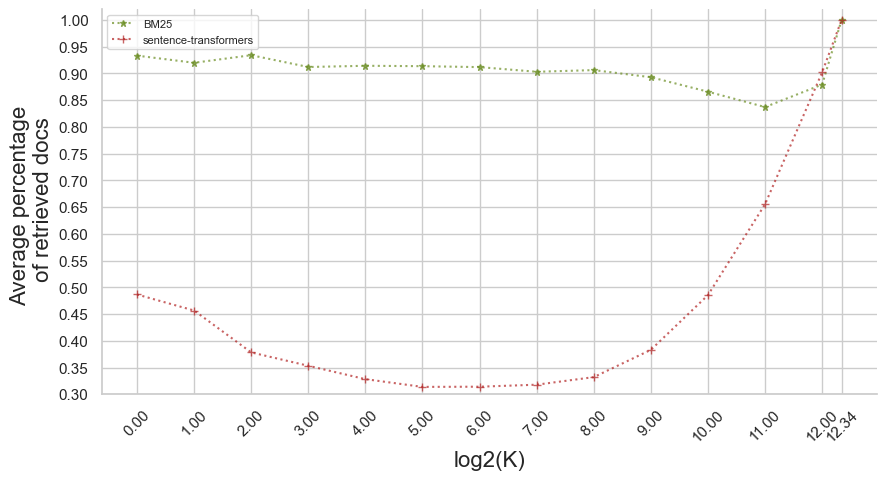

In [256]:
# plot evaluation
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sb.set_theme(style="whitegrid", rc=custom_params)
plt.figure(figsize=(10, 5))
K = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 5183]
x = sorted(np.around(np.log2(list(set(df_eval_q_2["K"]))), 3))

y_trans = [df_eval_q_2[(df_eval_q_2["K"] == k) & (df_eval_q_2["method"] == "TRANS")]["best_is_in"].mean()/k for k in K]
y_bm25 = [df_eval_q_2[(df_eval_q_2["K"] == k) & (df_eval_q_2["method"] == "BM25")]["best_is_in"].mean()/k for k in K]

plt.xticks(x, rotation = 45)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.ylim(bottom=0.3, top=1.02) 
plt.xlabel("log2(K)", fontsize=16)
plt.ylabel("Average percentage \n of retrieved docs", fontsize=16)

plt.plot(x,
         y_bm25,
         linestyle=':', marker="*", color="olivedrab", ms=5, alpha=0.7, label="BM25")

plt.plot(x,
         y_trans,
         linestyle=':', marker="+", color="firebrick", ms=6, alpha=0.7, label="sentence-transformers")


plt.legend(fontsize=8)
plt.savefig('avg_perc_of_retr_docs.png', format='png', dpi=400, bbox_inches='tight')

## Evaluate ranking for each K' (K fixed for ground truth)

In [158]:
df_eval_2 = pd.DataFrame(columns = ['K', 'MRecall_2'])
for K in [2, 16, 64, 512, 2048]:
    df_tmp_recall = pd.DataFrame(columns = ['MRecall_' + str(K)])
    for k_1 in final_score.keys():
        if K == 2:
            df_tmp = pd.DataFrame([[k_1] + [mean_recall(final_score[K][0], final_score[k_1][1])]],
                                  columns = ['K', 'MRecall_' + str(K)])
            df_eval_2 = pd.concat([df_eval_2, df_tmp])
        else:
            df_tmp = pd.DataFrame([[mean_recall(final_score[K][0], final_score[k_1][1])]],
                                  columns = ['MRecall_' + str(K)])
            df_tmp_recall = pd.concat([df_tmp_recall, df_tmp])
    if K != 2:
        df_eval_2 = pd.concat([df_eval_2, df_tmp_recall], axis=1)          

In [159]:
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 4)
df_eval_2

,K,MRecall_2,MRecall_16,MRecall_64,MRecall_512,MRecall_2048
0,1,0.4933,0.0625,0.0156,0.0020,0.0005
0,2,0.9583,0.1250,0.0312,0.0039,0.0010
0,4,0.9967,0.2500,0.0625,0.0078,0.0020
0,8,1.0000,0.5000,0.1250,0.0156,0.0039
0,16,1.0000,0.9519,0.2500,0.0312,0.0078
0,32,1.0000,1.0000,0.5000,0.0625,0.0156
0,64,1.0000,1.0000,0.9571,0.1250,0.0312
0,128,1.0000,1.0000,0.9999,0.2500,0.0625
0,256,1.0000,1.0000,1.0000,0.5000,0.1250
0,512,1.0000,1.0000,1.0000,0.9718,0.2500


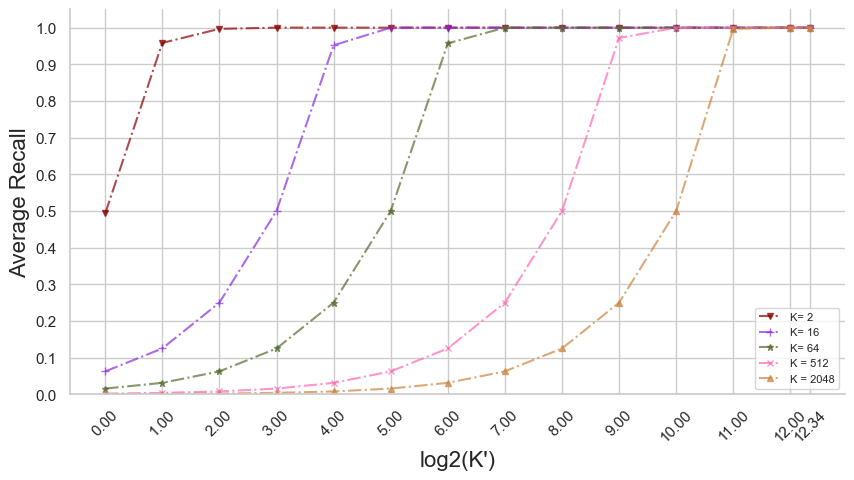

In [257]:
# plot evaluation
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sb.set_theme(style="whitegrid", rc=custom_params)
plt.figure(figsize=(10, 5))

x = np.around(np.log2(list(df_eval_2["K"])), 3)

plt.xticks(x, rotation = 45)
plt.yticks(np.arange(0, 1.01, 0.1))
plt.ylim(bottom=0., top=1.05) 
plt.xlabel("log2(K')", fontsize=16)
plt.ylabel("Average Recall", fontsize=16)

plt.plot(x,
         df_eval_2["MRecall_2"],
         ls='-.', color="darkred", marker="v", ms=5, alpha=0.7, label="K= 2")

plt.plot(x,
         df_eval_2["MRecall_16"],
         ls='-.', color="blueviolet", marker="+", ms=6, alpha=0.7, label="K= 16")

plt.plot(x,
         df_eval_2["MRecall_64"],
         ls='-.', color="darkolivegreen", marker="*", ms=5, alpha=0.7, label="K= 64")

plt.plot(x,
         df_eval_2["MRecall_512"],
         ls='-.', color="hotpink", marker="x", ms=5, alpha=0.7, label="K = 512")

plt.plot(x,
         df_eval_2["MRecall_2048"],
         ls='-.', color="peru", marker="^", ms=5, alpha=0.7, label="K = 2048")

plt.legend(fontsize=8)
plt.savefig('eval_1_fixed_K.png', format='png', dpi=400, bbox_inches='tight')

# SECOND PART EVALUATION

## Functions

In [167]:
# determine the mean recall among all queries
def mean_recall(ground_truth, y_hat):
    m_recall = 0
    # for each query determine recall
    for k_query in ground_truth.keys():
        # extract relevant document retrieved
        tmp_set = set.intersection(set(ground_truth[k_query].keys()), set(y_hat[k_query].keys()))
        # compute recall for specific query
        m_recall += len(tmp_set) / len(list(ground_truth[k_query].keys()))
    # compute the mean among all recall
    return m_recall / len(ground_truth)

# extract top k docs for each query
def extract_k(scores, k):
    k_score = {}
    # for each query
    for k_q in scores.keys():
        # I don't need to sort since that they are just sorted,
        # but for completeness I still doing
        k_score[k_q] = dict(sorted(scores[k_q].items(), reverse=True, key=itemgetter(1))[:k])
    return k_score
    

## Load dictionaries

In [165]:
# load dictionaries and extract them from array
d_score_TAAT = np.load('d_score_TAAT.npy', allow_pickle=True).item()
d_score_FAISS = np.load('d_score_FAISS.npy', allow_pickle=True).item()
d_score_qrels = np.load('qrels.npy', allow_pickle=True).item()

## Evaluate ranking for TAAT with different K

In [188]:
num_docs = len(d_score_FAISS[list(d_score_FAISS.keys())[0]])
# df contains results
df_eval_3 = pd.DataFrame(columns = ['K', 'MAP', 'MRR', 'NDCG', 'MRecall'])
for k in [2**i for i in range(13)] + [num_docs]:
    y_hat = extract_k(d_score_TAAT, k)
    eval_tmp = list((evaluate(d_score_qrels, y_hat, ["map", "mrr", "ndcg"])).items()) 
    df_tmp = pd.DataFrame([[k] + [ev[1] for ev in eval_tmp] + [mean_recall(d_score_qrels, y_hat)]],
                          columns = ['K', 'MAP', 'MRR', 'NDCG', 'MRecall'])
    df_eval_3 = pd.concat([df_eval_3, df_tmp])

('ndcg', 0.49750268333040737)
('ndcg', 0.5850708072605985)
('ndcg', 0.6137271495112548)
('ndcg', 0.6395035064476646)
('ndcg', 0.6523487750302)
('ndcg', 0.6591219720087841)
('ndcg', 0.6663523901360001)
('ndcg', 0.6686015612076378)
('ndcg', 0.673903456262631)
('ndcg', 0.6769172561408844)
('ndcg', 0.6795395730390622)
('ndcg', 0.6811053529239461)
('ndcg', 0.6821361887170215)
('ndcg', 0.6826369482037189)


In [182]:
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 4)
df_eval_3

0    0.5100
0    0.5783
0    0.5969
0    0.6081
0    0.6116
0    0.6128
0    0.6136
0    0.6137
0    0.6139
0    0.6140
0    0.6140
0    0.6140
0    0.6140
0    0.6140
Name: MRR, dtype: float64

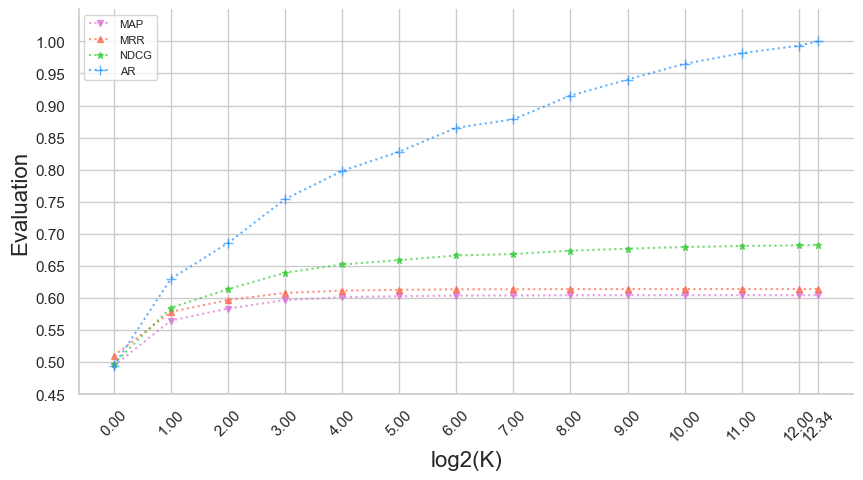

In [258]:
# plot evaluation
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sb.set_theme(style="whitegrid", rc=custom_params)
plt.figure(figsize=(10, 5))

x = np.around(np.log2(list(df_eval_3["K"])), 3)

plt.xticks(x, rotation = 45)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.ylim(bottom=0.45, top=1.05) 
plt.xlabel("log2(K)", fontsize=16)
plt.ylabel("Evaluation", fontsize=16)

plt.plot(x,
         df_eval_3["MAP"],
         linestyle=':', marker="v", color="orchid", ms=5, alpha=0.7, label="MAP")

plt.plot(x,
         df_eval_3["MRR"],
         linestyle=':', marker="^", color="tomato", ms=5, alpha=0.7, label="MRR")

plt.plot(x,
         df_eval_3["NDCG"],
         linestyle=':', marker="*", color="limegreen", ms=5, alpha=0.7, label="NDCG")

plt.plot(x,
         df_eval_3["MRecall"],
         linestyle=':', marker="+", color="dodgerblue", ms=7, alpha=0.7, label="AR")

plt.legend(fontsize=8)
plt.savefig('eval_2_TAAT.png', format='png', dpi=400, bbox_inches='tight')

### Understanding of above graph

In [226]:
qq = []
for k_q in d_score_qrels.keys():
    relevant_docs = list(d_score_qrels[k_q].keys())
    y_hat = list(d_score_TAAT[k_q].keys())
    value = 0
    for d in relevant_docs:
        value += y_hat.index(d)
    value = value / len(relevant_docs)
    qq.append(value)

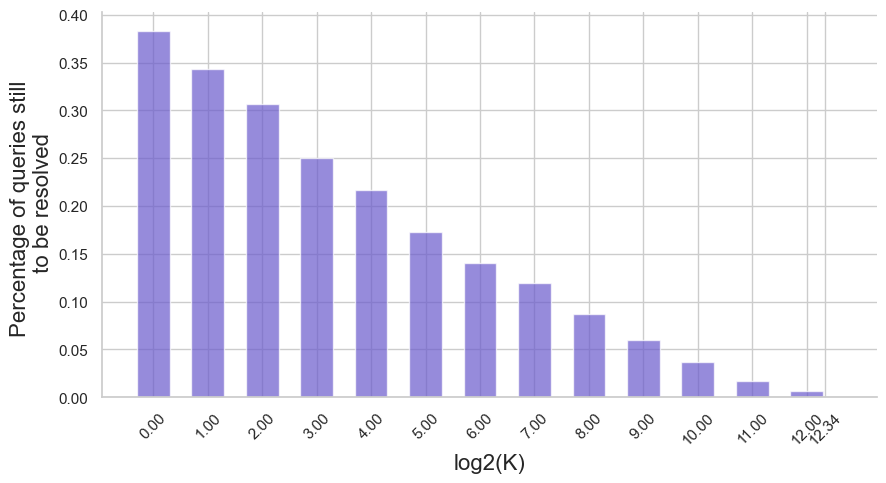

In [259]:
# plot evaluation
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sb.set_theme(style="whitegrid", rc=custom_params)
plt.figure(figsize=(10, 5))



x = np.around(np.log2([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 5183]), 3)
y = []
for i in x:
    tmp = [1 if q > 2**i else 0 for q in qq]
    y.append(sum(tmp) / 300)

plt.xticks(x, rotation = 45)
plt.yticks(np.arange(0, 1, 0.05))

plt.xlabel("log2(K)", fontsize=16)
plt.ylabel("Percentage of queries still \n to be resolved", fontsize=16)


plt.bar(x,
        y,
        color="slateblue", width = 0.6, alpha = 0.7)



plt.savefig('queries_still_to_be_resolved.png', format='png', dpi=400, bbox_inches='tight')

## Evaluate ranking for FAISS with different K

In [246]:
num_docs = len(d_score_FAISS[list(d_score_FAISS.keys())[0]])
# df contains results
df_eval_4 = pd.DataFrame(columns = ['K', 'MAP', 'MRR', 'NDCG', 'MRecall'])
for k in [2**i for i in range(13)] + [num_docs]:
    y_hat = extract_k(d_score_FAISS, k)
    eval_tmp = list((evaluate(d_score_qrels, y_hat, ["map", "mrr", "ndcg"])).items()) 
    df_tmp = pd.DataFrame([[k] + [ev[1] for ev in eval_tmp] + [mean_recall(d_score_qrels, y_hat)]],
                          columns = ['K', 'MAP', 'MRR', 'NDCG', 'MRecall'])
    df_eval_4 = pd.concat([df_eval_4, df_tmp])

In [247]:
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 4)
df_eval_4

,K,MAP,MRR,NDCG,MRecall
0,1,0.4772,0.4967,0.4813,0.4772
0,2,0.5369,0.5583,0.5567,0.5932
0,4,0.5703,0.5850,0.6049,0.6903
0,8,0.5862,0.5961,0.6342,0.7672
0,16,0.5908,0.5998,0.6467,0.8107
0,32,0.5939,0.6026,0.6608,0.8720
0,64,0.5949,0.6032,0.6673,0.9067
0,128,0.5952,0.6035,0.6715,0.9333
0,256,0.5954,0.6037,0.6761,0.9667
0,512,0.5955,0.6037,0.6788,0.9900


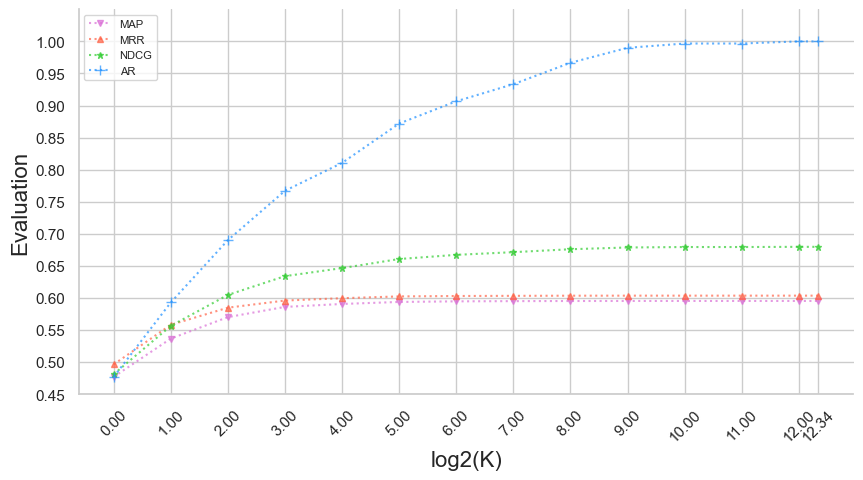

In [260]:
# plot evaluation
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sb.set_theme(style="whitegrid", rc=custom_params)
plt.figure(figsize=(10, 5))

x = np.around(np.log2(list(df_eval_4["K"])), 3)

plt.xticks(x, rotation = 45)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.ylim(bottom=0.45, top=1.05) 
plt.xlabel("log2(K)", fontsize=16)
plt.ylabel("Evaluation", fontsize=16)

plt.plot(x,
         df_eval_4["MAP"],
         linestyle=':', marker="v", color="orchid", ms=5, alpha=0.7, label="MAP")

plt.plot(x,
         df_eval_4["MRR"],
         linestyle=':', marker="^", color="tomato", ms=5, alpha=0.7, label="MRR")

plt.plot(x,
         df_eval_4["NDCG"],
         linestyle=':', marker="*", color="limegreen", ms=5, alpha=0.7, label="NDCG")

plt.plot(x,
         df_eval_4["MRecall"],
         linestyle=':', marker="+", color="dodgerblue", ms=7, alpha=0.7, label="AR")

plt.legend(fontsize=8)
plt.savefig('eval_2_FAISS.png', format='png', dpi=400, bbox_inches='tight')

## Evaluate combination of methods (Fusion)

### Without Standardization

In [274]:
# merging score between 2 methods with or without standardization and with hyperparameter alpha
def merging_score(score_1, score_2, queries_k, docs_k, alpha = 0.5, std = False):
    merged_score = {}
    scaler_1 = MinMaxScaler()
    scaler_2 = MinMaxScaler()
    # for each query
    for k_q in queries_k:
        if std:
            # create the right container to apply fit_transform function
            score_1_to_trans = [[i] for i in list(score_1[k_q].values())]
            score_2_to_trans = [[i] for i in list(score_2[k_q].values())]
            # fit and transform
            std_score_1 = (scaler_1.fit_transform(score_1_to_trans)).squeeze()
            std_score_2 = (scaler_2.fit_transform(score_2_to_trans)).squeeze()
            # recreate std rappresentation (key_d, score)
            std_score_1 = dict([(d_key, score) for (d_key, score) in zip(score_1[k_q].keys(), std_score_1)])
            std_score_2 = dict([(d_key, score) for (d_key, score) in zip(score_2[k_q].keys(), std_score_2)])
            # merging score
            merged_score[k_q] = dict(sorted([(k_d, (1 - alpha) * std_score_1.get(k_d, 0) + alpha * std_score_2.get(k_d, 0)) for k_d in docs_k], 
                                            reverse=True, key=itemgetter(1)))
        else:
            # merging score
            merged_score[k_q] = dict(sorted([(k_d, (1 - alpha) * score_1[k_q].get(k_d, 0) + alpha * score_2[k_q].get(k_d, 0)) for k_d in docs_k], 
                                       reverse=True, key=itemgetter(1)))
    return merged_score
        

In [264]:
num_docs = len(d_score_TRANS[list(d_score_TRANS.keys())[0]])
k_queries = d_score_BM25.keys()
k_docs = d_score_TRANS['1'].keys()
# df contains results
df_eval_5 = pd.DataFrame(columns = ['K', 'a', 'MAP', 'MRR', 'NDCG', 'MRecall'])
for a in np.arange(0., 1.2, 0.2):
    merged_score = merging_score(d_score_BM25, d_score_TRANS, k_queries, k_docs, alpha=a)
    for k in [2**i for i in range(13)] + [num_docs]:
        y_hat = extract_k(merged_score, k)
        eval_tmp = list((evaluate(d_score_qrels, y_hat, ["map", "mrr", "ndcg"])).items()) 
        df_tmp = pd.DataFrame([[k, a] + [ev[1] for ev in eval_tmp] + [mean_recall(d_score_qrels, y_hat)]],
                              columns = ['K', 'a', 'MAP', 'MRR', 'NDCG', 'MRecall'])
        df_eval_5 = pd.concat([df_eval_5, df_tmp])

In [265]:
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 4)
df_eval_5

,K,a,MAP,MRR,NDCG,MRecall
0,1,0.0,0.4942,0.5100,0.4975,0.4942
0,2,0.0,0.5649,0.5783,0.5851,0.6300
0,4,0.0,0.5836,0.5969,0.6137,0.6857
0,8,0.0,0.5969,0.6081,0.6395,0.7540
0,16,0.0,0.6014,0.6116,0.6523,0.7981
...,...,...,...,...,...,...
0,512,1.0,0.5955,0.6037,0.6788,0.9900
0,1024,1.0,0.5955,0.6037,0.6795,0.9967
0,2048,1.0,0.5955,0.6037,0.6795,0.9967
0,4096,1.0,0.5955,0.6037,0.6798,1.0000


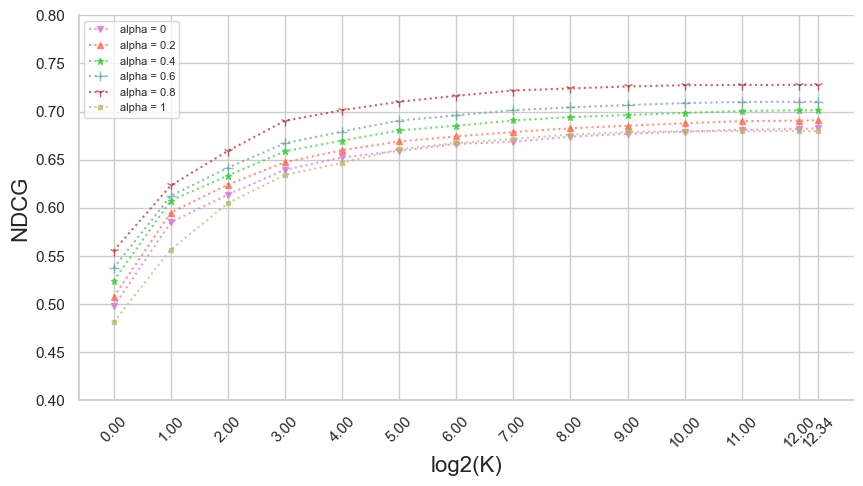

In [267]:
# plot evaluation
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sb.set_theme(style="whitegrid", rc=custom_params)
plt.figure(figsize=(10, 5))

x = np.around(sorted(np.log2(list(set(df_eval_5["K"])))), 3)

plt.xticks(x, rotation = 45)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.ylim(bottom=0.4, top=.8) 
plt.xlabel("log2(K)", fontsize=16)
plt.ylabel("NDCG", fontsize=16)

plt.plot(x,
         df_eval_5[np.around(df_eval_5["a"], 1) == 0.]["NDCG"],
         linestyle=':', marker="v", color="orchid", ms=5, alpha=0.7, label="alpha = 0")

plt.plot(x,
         df_eval_5[np.around(df_eval_5["a"], 1) == 0.2]["NDCG"],
         linestyle=':', marker="^", color="tomato", ms=5, alpha=0.7, label="alpha = 0.2")

plt.plot(x,
         df_eval_5[np.around(df_eval_5["a"], 1) == 0.4]["NDCG"],
         linestyle=':', marker="*", color="limegreen", ms=5, alpha=0.7, label="alpha = 0.4")

plt.plot(x,
         df_eval_5[np.around(df_eval_5["a"], 1) == 0.6]["NDCG"],
         linestyle=':', marker="+", color="cadetblue", ms=7, alpha=0.7, label="alpha = 0.6")
plt.plot(x,
         df_eval_5[np.around(df_eval_5["a"], 1) == 0.8]["NDCG"],
         linestyle=':', marker="1", color="firebrick", ms=7, alpha=0.7, label="alpha = 0.8")

plt.plot(x,
         df_eval_5[np.around(df_eval_5["a"], 1) == 1]["NDCG"],
         linestyle=':', marker="s", color="darkkhaki", ms=3, alpha=0.7, label="alpha = 1")

plt.legend(fontsize=8)
plt.savefig('eval_2_MERGE.png', format='png', dpi=400, bbox_inches='tight')

### With Standardization

In [268]:
num_docs = len(d_score_TRANS[list(d_score_TRANS.keys())[0]])
k_queries = d_score_BM25.keys()
k_docs = d_score_TRANS['1'].keys()
# df contains results
df_eval_6 = pd.DataFrame(columns = ['K', 'a', 'MAP', 'MRR', 'NDCG', 'MRecall'])
for a in np.arange(0., 1.2, 0.2):
    merged_score = merging_score(d_score_BM25, d_score_TRANS, k_queries, k_docs, alpha=a, std=True)
    for k in [2**i for i in range(13)] + [num_docs]:
        y_hat = extract_k(merged_score, k)
        eval_tmp = list((evaluate(d_score_qrels, y_hat, ["map", "mrr", "ndcg"])).items()) 
        df_tmp = pd.DataFrame([[k, a] + [ev[1] for ev in eval_tmp] + [mean_recall(d_score_qrels, y_hat)]],
                              columns = ['K', 'a', 'MAP', 'MRR', 'NDCG', 'MRecall'])
        df_eval_6 = pd.concat([df_eval_6, df_tmp])

In [269]:
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 4)
df_eval_6

,K,a,MAP,MRR,NDCG,MRecall
0,1,0.0,0.4942,0.5100,0.4975,0.4942
0,2,0.0,0.5649,0.5783,0.5851,0.6300
0,4,0.0,0.5836,0.5969,0.6137,0.6857
0,8,0.0,0.5969,0.6081,0.6395,0.7540
0,16,0.0,0.6014,0.6116,0.6523,0.7981
...,...,...,...,...,...,...
0,512,1.0,0.5955,0.6037,0.6788,0.9900
0,1024,1.0,0.5955,0.6037,0.6795,0.9967
0,2048,1.0,0.5955,0.6037,0.6795,0.9967
0,4096,1.0,0.5955,0.6037,0.6798,1.0000


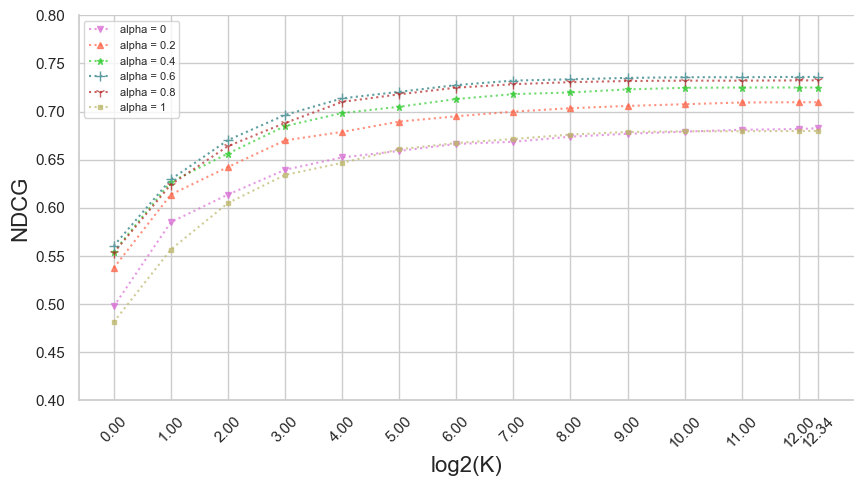

In [270]:
# plot evaluation
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sb.set_theme(style="whitegrid", rc=custom_params)
plt.figure(figsize=(10, 5))

x = np.around(sorted(np.log2(list(set(df_eval_6["K"])))), 3)

plt.xticks(x, rotation = 45)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.ylim(bottom=0.4, top=.8) 
plt.xlabel("log2(K)", fontsize=16)
plt.ylabel("NDCG", fontsize=16)

plt.plot(x,
         df_eval_6[np.around(df_eval_6["a"], 1) == 0.]["NDCG"],
         linestyle=':', marker="v", color="orchid", ms=5, alpha=0.7, label="alpha = 0")

plt.plot(x,
         df_eval_6[np.around(df_eval_6["a"], 1) == 0.2]["NDCG"],
         linestyle=':', marker="^", color="tomato", ms=5, alpha=0.7, label="alpha = 0.2")

plt.plot(x,
         df_eval_6[np.around(df_eval_6["a"], 1) == 0.4]["NDCG"],
         linestyle=':', marker="*", color="limegreen", ms=5, alpha=0.7, label="alpha = 0.4")

plt.plot(x,
         df_eval_6[np.around(df_eval_6["a"], 1) == 0.6]["NDCG"],
         linestyle=':', marker="+", color="cadetblue", ms=7, label="alpha = 0.6")
plt.plot(x,
         df_eval_6[np.around(df_eval_6["a"], 1) == 0.8]["NDCG"],
         linestyle=':', marker="1", color="firebrick", ms=7, alpha=0.7, label="alpha = 0.8")

plt.plot(x,
         df_eval_6[np.around(df_eval_6["a"], 1) == 1]["NDCG"],
         linestyle=':', marker="s", color="darkkhaki", ms=3, alpha=0.7, label="alpha = 1")

plt.legend(fontsize=8)
plt.savefig('eval_2_MERGE_std.png', format='png', dpi=400, bbox_inches='tight')

### Comparison between with or without standardization

In [275]:
num_docs = len(d_score_TRANS[list(d_score_TRANS.keys())[0]])
k_queries = d_score_BM25.keys()
k_docs = d_score_TRANS['1'].keys()
# df contains results
df_eval_7 = pd.DataFrame(columns = ['K', 'a', 'std', 'MAP', 'MRR', 'NDCG', 'MRecall'])
for a in np.arange(0., 1.05, 0.05):
    # compute merge
    merged_score_std = merging_score(d_score_BM25, d_score_TRANS, k_queries, k_docs, alpha=a, std=True)
    merged_score = merging_score(d_score_BM25, d_score_TRANS, k_queries, k_docs, alpha=a)
    # extract top k
    y_hat_std = extract_k(merged_score_std, 16)
    y_hat = extract_k(merged_score, 16)
    # evaluation
    eval_tmp = list((evaluate(d_score_qrels, y_hat, ["map", "mrr", "ndcg"])).items()) 
    eval_tmp_std = list((evaluate(d_score_qrels, y_hat_std, ["map", "mrr", "ndcg"])).items()) 
    # write in df
    df_tmp = pd.DataFrame([[16, a, "no"] + [ev[1] for ev in eval_tmp] + [mean_recall(d_score_qrels, y_hat)], 
                           [16, a, "yes"] + [ev[1] for ev in eval_tmp_std] + [mean_recall(d_score_qrels, y_hat_std)]],
                          columns = ['K', 'a', 'std', 'MAP', 'MRR', 'NDCG', 'MRecall'])
    df_eval_7 = pd.concat([df_eval_7, df_tmp])

In [276]:
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 4)
df_eval_7

,K,a,std,MAP,MRR,NDCG,MRecall
0,16,0.00,no,0.6014,0.6116,0.6523,0.7981
1,16,0.00,yes,0.6014,0.6116,0.6523,0.7981
0,16,0.05,no,0.6020,0.6119,0.6528,0.7981
1,16,0.05,yes,0.6107,0.6207,0.6598,0.7988
0,16,0.10,no,0.6040,0.6141,0.6546,0.7988
1,16,0.10,yes,0.6208,0.6306,0.6689,0.8054
0,16,0.15,no,0.6050,0.6151,0.6555,0.7988
1,16,0.15,yes,0.6291,0.6387,0.6761,0.8099
0,16,0.20,no,0.6107,0.6208,0.6599,0.7988
1,16,0.20,yes,0.6324,0.6422,0.6789,0.8099


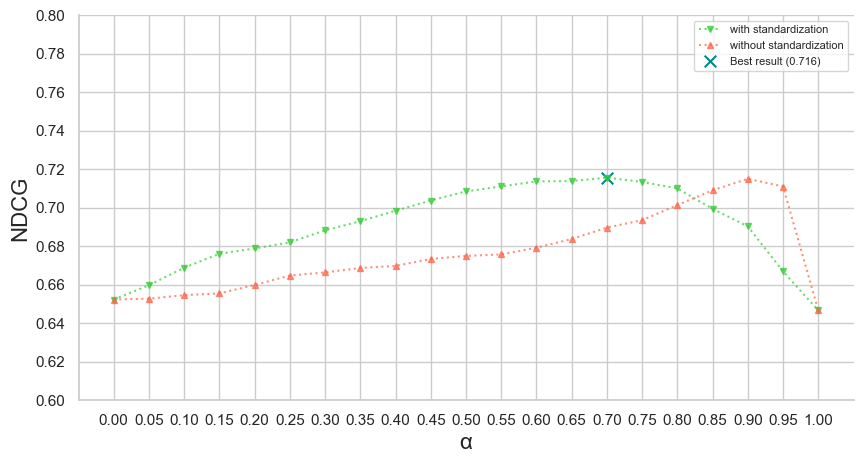

In [277]:
# plot evaluation
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sb.set_theme(style="whitegrid", rc=custom_params)
plt.figure(figsize=(10, 5))

x = np.around(sorted(list(set(df_eval_7["a"]))), 2)

plt.xticks(x)
plt.yticks(np.arange(0, 1.01, 0.02))
plt.ylim(bottom=0.6, top=.8) 
plt.xlabel("α", fontsize=16)
plt.ylabel("NDCG", fontsize=16)

plt.plot(x,
         df_eval_7[df_eval_7["std"] == "yes"]["NDCG"],
         linestyle=':', marker="v", color="limegreen", ms=5, alpha=0.7, label="with standardization")

plt.plot(x,
         df_eval_7[df_eval_7["std"] == "no"]["NDCG"],
         linestyle=':', marker="^", color="tomato", ms=5, alpha=0.7, label="without standardization")

# return the row where there is the highest ndcg value
best_ndcg = df_eval_7.iloc[df_eval_7["NDCG"].argmax()]
plt.scatter(best_ndcg["a"],
         best_ndcg["NDCG"],
         marker="x", color="darkcyan", label=f"Best result ({np.around(best_ndcg['NDCG'], 3)})", s=70)


plt.legend(fontsize=8)
plt.savefig('eval_2_compare_std_nostd.png', format='png', dpi=400, bbox_inches='tight')

### Proof that BM25 dominates over NN

In [319]:
l_score_TRANS = []
for d in d_score_TRANS.values():
    l_score_TRANS += list(d.values())

In [326]:
print("TRANS MIN MAX")
min(l_score_TRANS), max(l_score_TRANS)

TRANS MIN MAX


(-0.28320944, 0.87761027)

In [324]:
l_score_BM = []
for d in d_score_BM25.values():
    l_score_BM += list(d.values())

In [327]:
print("BM25 MIN MAX")
min(l_score_BM), max(l_score_BM)

BM25 MIN MAX


(0.0006328811571041453, 20.294379821458744)